# This Code is Implemented in google colab

###  INSTALLING CORRECT TENSORFLOW VERSION in Google Colab

In [ ]:
!pip install tensorflow==1.12.0
import tensorflow as tf

In [15]:
print(tf.__version__)

1.12.0


###  Import Libraries

In [16]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops

###  Upload Data

In [17]:
from google.colab import files
uploaded = files.upload()

Saving test_signs.h5 to test_signs.h5
Saving train_signs.h5 to train_signs.h5


###  Loading Data

In [18]:
def load_dataset():
    train_dataset = h5py.File('train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


In [19]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

###  Visualizing Data

y = 2


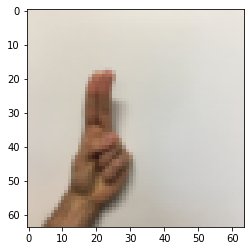

In [20]:
index = 10
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

###  One hot encoding

In [21]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

###  Reshaping and Normalization

In [22]:
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
# Normalize image vectors
X_train = X_train_flatten / 255.
X_test = X_test_flatten / 255.
# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

print("number of training examples = " + str(X_train.shape[1]))
print("number of test examples = " + str(X_test.shape[1]))
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


# Neural Network in Single Layer Tensorflow

#### The model is Linear -> Softmax
#### The work flow in Tenssorflow is as follows.
##### 1. Define the placeholders or the variables
##### 2. Define the relationship between the sessions
##### 3. Define and run the session feeding in the values for placeholder
##### 4. Close the session

### Create Placeholder

In [1]:
def create_placeholders(n_x, n_y):

    X = tf.placeholder(tf.float32, [n_x, None], name="X")
    Y = tf.placeholder(tf.float32, [n_y, None], name="Y")    
    
    return X, Y

### Initialization

In [26]:
def initialize_parameters():
   
    # The initializer can be specified here as zero, random or xavier

    W1 = tf.get_variable("W1", [6, 12288], initializer = tf.random_normal_initializer(seed=1))
    b1 = tf.get_variable("b1", [6, 1], initializer = tf.zeros_initializer())
    
   
    parameters = {"W1": W1,
                  "b1": b1}
    
    return parameters

### Forward propagation in Tensorflow

In [5]:
def forward_propagation(X, parameters):
   
     
    W1 = parameters['W1']
    b1 = parameters['b1']
    
    ### START CODE HERE ### (approx. 5 lines)              # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    
    return Z1

### Compute cost

In [30]:
def compute_cost(Z1, Y):
   
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z1)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return cost

In [34]:
Y_train.shape

(6, 1080)

### Backpropagation

#### We dont need to write a seperate column for it. Backpropagation is just a one line code in TensorFlow

### Model

In [43]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, print_cost = True):
   
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z1 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z1, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch

            # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
            optimize ,cost_iteration = sess.run([optimizer, cost], feed_dict={X: X_train, Y: Y_train})
                
            epoch_cost += cost_iteration / m

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z1), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Cost after epoch 0: 0.108263
Cost after epoch 100: 0.081665
Cost after epoch 200: 0.071346
Cost after epoch 300: 0.061292
Cost after epoch 400: 0.051241
Cost after epoch 500: 0.041232
Cost after epoch 600: 0.032282
Cost after epoch 700: 0.026305
Cost after epoch 800: 0.023250
Cost after epoch 900: 0.021226
Cost after epoch 1000: 0.019677
Cost after epoch 1100: 0.018690
Cost after epoch 1200: 0.018170
Cost after epoch 1300: 0.017964
Cost after epoch 1400: 0.017878


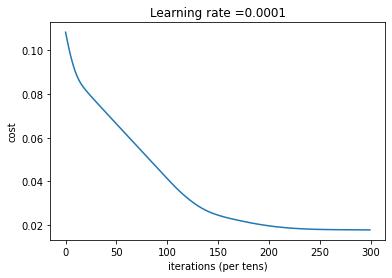

Parameters have been trained!
Train Accuracy: 0.17777778
Test Accuracy: 0.18333334


In [44]:
parameters = model(X_train, Y_train, X_test, Y_test)